In [1]:
%matplotlib inline

import time
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from joblib import Parallel, delayed
from PIL import Image, ImageDraw, ImageFont
from matplotlib import animation, pyplot as plt
from scipy.optimize import linear_sum_assignment
plt.rc('animation', html='html5')

In [2]:
def pseudo_cost_assign(P, S):
    n = P.shape[0]
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = -P[i]@S[j]

    rows, cols = linear_sum_assignment(K)
    return rows, cols, K[rows, cols]

def text2cord(text, text_size):
    myfont = ImageFont.truetype("Pixelation.ttf", text_size)
    left, _, right, bottom = myfont.getbbox(text)
    size = right - left, bottom
    img = Image.new("1",size,"black")
    draw = ImageDraw.Draw(img)
    draw.text((0, 0), text, "white", font=myfont)
    pixels = np.array(img, dtype=np.uint8)
    return np.array([np.where(pixels == 1)[1],
                     pixels.shape[0]-np.where(pixels == 1)[0]]).T.astype(np.double)

def get_sp(s_text, p_text, text_size=15):
    s_cord = text2cord(s_text, text_size)
    p_cord = text2cord(p_text, text_size)
    
    if(s_cord.shape[0] < p_cord.shape[0]):
        return s_cord, p_cord[:s_cord.shape[0]]
    if(s_cord.shape[0] > p_cord.shape[0]):
        return s_cord[:p_cord.shape[0]], p_cord
    else:
        return s_cord, p_cord

def get_A(S):
    A = []
    n = S.shape[0]*2
    S2 = np.linalg.norm(S[1])
    q2_q1 = np.array([np.eye(n)[2]-np.eye(n)[0], np.eye(n)[3]-np.eye(n)[1]])
        
    for i in range(2, int(n/2)):
        A.append((S2*(np.eye(n)[i*2]-np.eye(n)[0])) - np.dot([S[i, 0], -S[i, 1]], q2_q1))
        A.append((S2*(np.eye(n)[(i*2)+1]-np.eye(n)[1])) - np.dot([S[i, 1],  S[i, 0]], q2_q1))
    return np.array(A)

def get_ads(P, S):            
    n = P.shape[0]
    q = cp.Variable(n*2)
    Q = cp.reshape(q, (2, n), order='F').T
    y = cp.norm(Q-P, 2, 1)
    t = cp.Variable(n)
    Ones = np.ones(n)
    A = get_A(S)
    prob = cp.Problem(cp.Minimize(Ones@t), [y <= t, A@q == 0])
    prob.solve()
    return np.array(Q.value)

def get_aadt(P, S, epsilon=1e-6):
    P_og = np.copy(P)
    P = np.copy(P)
    index_0 = 0
    index_1 = 1
    costs = []
    for k in range(20):                       
        theta = -get_angle(S[0], S[1])
        S = rot(S, theta)
        P = rot(P, theta)
        P -= S[0]
        S -= S[0]
        S = get_ads(P, S)   
        
        rows, cols, K = pseudo_cost_assign(P, S)
        index_0 = np.where(rows==index_0)[0][0]
        index_1 = np.where(rows==index_1)[0][0]
        S = S[cols]
        P = P[rows]
        
        costs.append(np.linalg.norm(P-S))
        if (len(costs) > 1):
            if(np.abs(costs[-1]-costs[-2]) < epsilon):
                print("Ending after iteration: ", k+1)
                break

    theta = get_angle(P_og[0], P_og[1])-get_angle(P[index_0], P[index_1])
    P = rot(P, theta)
    S = rot(S, theta)
    S += P_og[0]-P[index_0]
    P += P_og[0]-P[index_0]
    return P_og, S

def rot(arr, theta):
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    for i in range(arr.shape[0]):
        arr[i] = R@arr[i]
    return arr

def get_angle(pointA, pointB):
    changeInX = pointB[0] - pointA[0]
    changeInY = pointB[1] - pointA[1]
    return np.arctan2(changeInY,changeInX)

# Variable Translation and Scale

344


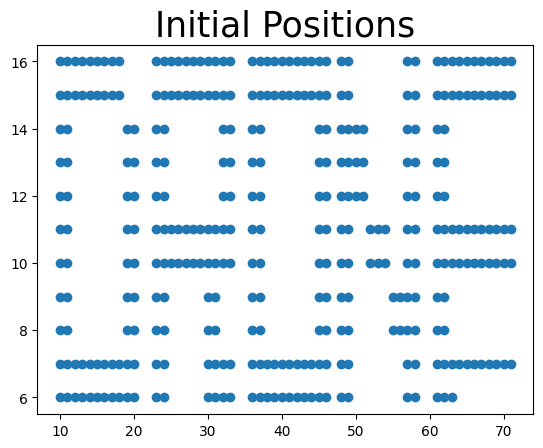

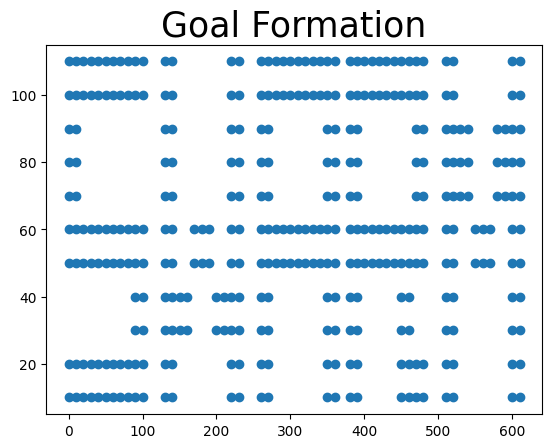

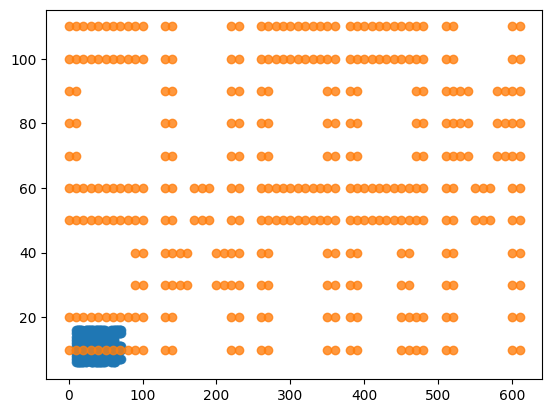

In [3]:
P, S = get_sp("DRONE", "SWARM")
P += [10, 5]
S *= 10
n = P.shape[0]
print(n)

plt.title("Initial Positions", size=25)
plt.scatter(P[:, 0], P[:, 1], color='C0')
plt.show()

plt.title("Goal Formation", size=25)
plt.scatter(S[:, 0], S[:, 1], color='C0')
plt.show()

plt.scatter(P[:, 0], P[:, 1], color='C0', alpha=0.8)
plt.scatter(S[:, 0], S[:, 1], color='C1', alpha=0.8)
plt.show()

In [4]:
P, S = get_sp("DRONE", "SWARM")
P = P[:, :2]
S = S[:, :2]
n = P.shape[0]
print("Number of points:", n)
P_og = np.copy(P)

Number of points: 344


In [5]:
rows, cols, K = pseudo_cost_assign(P, S)

ds = np.sum([S[j]@S[j] for j in range(n)])
alpha = ((np.sum(P, axis = 0)@np.sum(S, axis = 0))+(n*np.sum(K)))/((np.sum(S, axis = 0)@np.sum(S, axis = 0))-(n*ds))
d = (np.sum(P, axis = 0) - (alpha*np.sum(S, axis = 0)))/n
Q = (S*alpha)+d

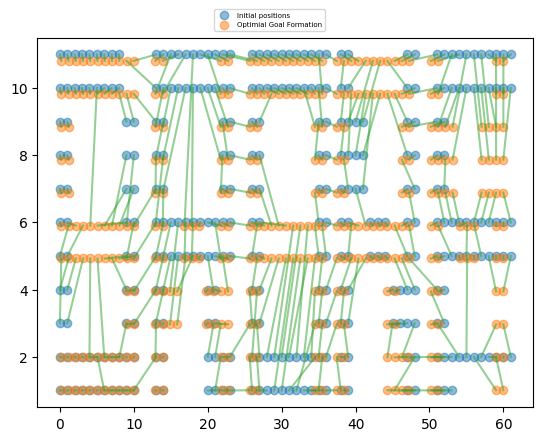

In [6]:
plt.scatter(P[:, 0], P[:, 1], color='C0', alpha=0.5, label='Initial positions')
plt.scatter(Q[:, 0], Q[:, 1], color='C1', alpha=0.5, label='Optimial Goal Formation')
plt.plot([P[rows][:, 0], Q[cols, 0]], [P[rows][:, 1], Q[cols, 1]], 'C2', alpha=0.5)
plt.legend(bbox_to_anchor=(0.35, 1.01), prop={'size': 5})
plt.show()

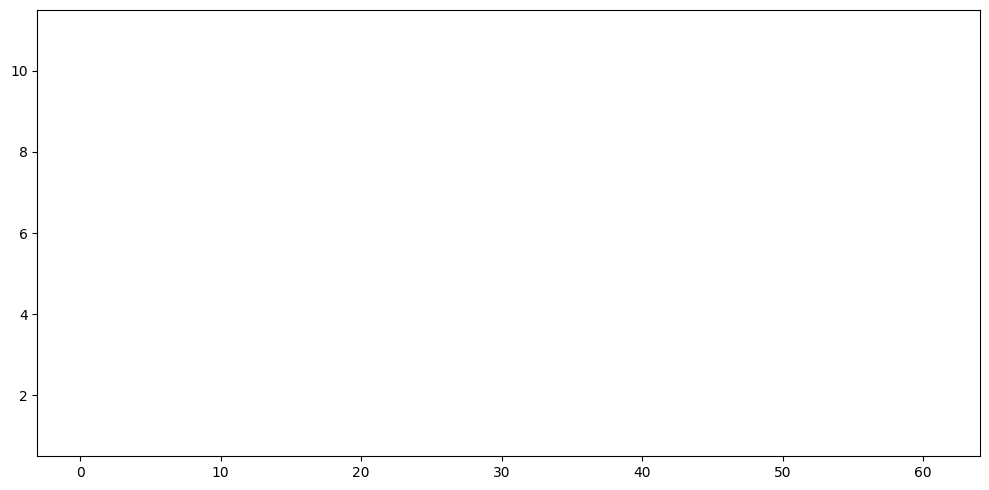

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)   
ax.scatter(*(P[rows][:, :2].T + (((Q[cols][:, :2].T - P[rows][:, :2].T)/40)*0)), color="C0")
fig.set_size_inches(10, 5, True)
fig.tight_layout()
ax.clear()
anim = animation.ArtistAnimation(fig, [[ax.scatter(x, y, color="C0")] for x, y in [(P[rows][:, :2].T + (((Q[cols][:, :2].T - P[rows][:, :2].T)/39)*i)) for i in range(40)]])
anim

# Variable Rotation, Transulation and Scale with fixed assignment

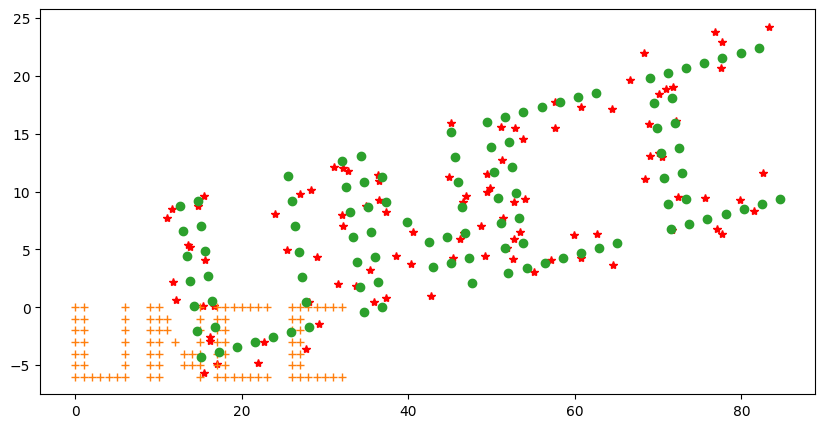

In [8]:
S = text2cord("UNCC", 10)[:, :2]
S -= S[0]
S[1, 1] = 0
n = S.shape[0]

theta = 0.2
alpha = 2.2
d = [10, 6]
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
P = np.copy(S)
for j in range(n):
    P[j] = alpha*R@S[j]+d
P += 5*np.random.rand(n,2)
Q = get_ads(P, S)

plt.figure(figsize=(10, 5))
plt.plot(P[:, 0], P[:, 1], '*', color='r', alpha=1)
plt.plot(S[:, 0], S[:, 1], '+', color='C1', alpha=1)
plt.plot(Q[:, 0], Q[:, 1], 'o', color='C2', alpha=1)
plt.show()

# Iterative Variable Rotation, Transulation, Scale and Assignments

Number of points: 344


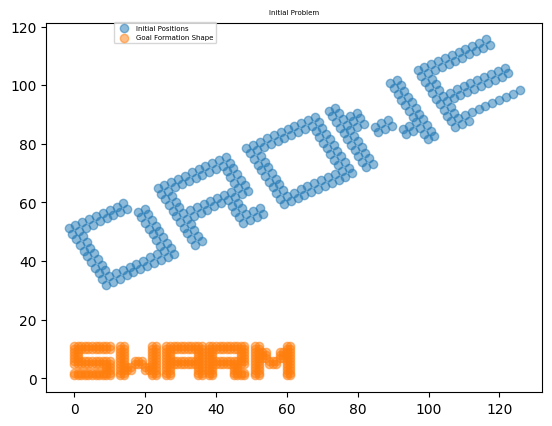

Ending after iteration:  4


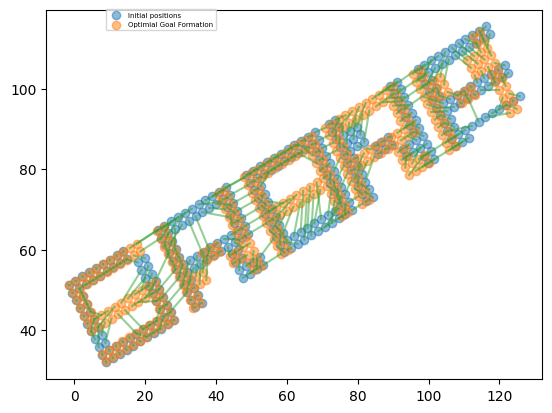

Final Cost 78.56219985348122


In [9]:
P, S = get_sp("DRONE", "SWARM")
P = P[:, :2]
S = S[:, :2]
n = P.shape[0]
print("Number of points:", n)

theta = 0.5
alpha = 2.2
d = [10, 30]
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
for i in range(n):
    P[i] = (alpha*R@P[i])+d
P_og = np.copy(P)

plt.figure()
plt.title("Initial Problem", size=5)
plt.scatter(P[:, 0], P[:, 1], alpha=0.5, color='C0', label="Initial Positions")
plt.scatter(S[:, 0], S[:, 1], alpha=0.5, color='C1', label="Goal Formation Shape")
plt.legend(bbox_to_anchor=(0.35, 1.01), prop={'size': 5})
plt.show()

P, S = get_aadt(P, S)

plt.figure()
plt.scatter(P[:, 0], P[:, 1], color='C0', alpha=0.5, label='Initial positions')
plt.scatter(S[:, 0], S[:, 1], color='C1', alpha=0.5, label='Optimial Goal Formation')
plt.plot([P[:, 0], S[:, 0]], [P[:, 1], S[:, 1]], 'C2', alpha=0.5)
plt.legend(bbox_to_anchor=(0.35, 1.01), prop={'size': 5})
plt.show()

print("Final Cost", np.linalg.norm(P-S))

In [ ]:
p_xy = []
s_xy = []
plot_xy = []
title_data = []

def plot_shape(P, S, P_og, index_0, index_1, title):
    theta = get_angle(P_og[0], P_og[1])-get_angle(P[index_0], P[index_1])
    P = rot(P, theta)
    S = rot(S, theta)
    S += P_og[0]-P[index_0]
    P = np.copy(P_og)
    
    print("{} Cost: {}".format(title, np.linalg.norm(P-S)))

    s_xy.append([S[:, 0], S[:, 1]])
    p_xy.append([P[:, 0], P[:, 1]])
    plot_xy.append([[P[:, 0], S[:, 0]], [P[:, 1], S[:, 1]]])
    title_data.append(title)

def get_aadt(P, S, epsilon=1e-6):
    P_og = np.copy(P)
    index_0 = 0
    index_1 = 1
    costs = []
    
    s_xy.append([S[:, 0], S[:, 1]])
    p_xy.append([P[:, 0], P[:, 1]])
    plot_xy.append([[P[:, 0], S[:, 0]], [P[:, 1], S[:, 1]]])
    title_data.append("Initial Shape and Assignments")

    for k in range(20):       
        rows, cols, K = pseudo_cost_assign(P, S)
        index_0 = np.where(rows==index_0)[0][0]
        index_1 = np.where(rows==index_1)[0][0]
        S = S[cols]
        P = P[rows]
        
        plot_shape(np.copy(P), np.copy(S), np.copy(P_og), index_0, index_1, "Update Assignments")
        
        theta = -get_angle(S[0], S[1])
        S = rot(S, theta)
        P = rot(P, theta)
        P -= S[0]
        S -= S[0]
        S = get_ads(P, S)
        
        plot_shape(np.copy(P), np.copy(S), np.copy(P_og), index_0, index_1, "Update Formation Parameters")       
        
        costs.append(np.linalg.norm(P-S))
        if (len(costs) > 1):
            if(np.abs(costs[-1]-costs[-2]) < epsilon):
                print("Ending after iteration: ", k+1)
                break
                
    theta = get_angle(P_og[0], P_og[1])-get_angle(P[index_0], P[index_1])
    P = rot(P, theta)
    S = rot(S, theta)
    S += P_og[0]-P[index_0]
    P = np.copy(P_og)
    return P_og, S
    
P, S = get_sp("DRONE", "SWARM")
P = P[:, :2]
S = S[:, :2]
n = P.shape[0]
print("Number of points:", n)

theta = 0.5
alpha = 2.2
d = [10, 30]
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
for i in range(n):
    P[i] = (alpha*R@P[i])+d
P_og = np.copy(P)

P, S = get_aadt(P, S)

print("Final Cost", np.linalg.norm(P-S))

def update_plot(i):
    plt.cla()
    plt.scatter(*s_xy[i], color='C0', label='Initial positions')
    plt.scatter(*p_xy[i], color='C1', label='Goal Formation')
    plt.plot(*plot_xy[i], color='C2')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(prop={'size': 5})
    plt.title(title_data[i], size=5)

fig = plt.figure()
plt.scatter(*s_xy[0], color='C0', label='Initial positions')
plt.scatter(*p_xy[0], color='C1', label='Goal Formation')
plt.plot(*plot_xy[0], color='C2')
xlim=plt.xlim()
ylim=plt.ylim()
plt.title(title_data[0], size=5)
plt.legend(prop={'size': 5})
plt.tight_layout()
    
ani = animation.FuncAnimation(fig, update_plot, frames=range(len(s_xy)), interval=1500)
ani

Number of points: 344
Update Assignments Cost: 1447.1384897244998
Update Formation Parameters Cost: 147.57428715060567
Update Assignments Cost: 89.3352427518094
Update Formation Parameters Cost: 79.65033583282708
Update Assignments Cost: 78.47534777138193
Update Formation Parameters Cost: 78.56219985182985
Update Assignments Cost: 78.56219985182985
Update Formation Parameters Cost: 78.56219985347812
Ending after iteration:  4
Final Cost 78.56219985347812


# Iterative Variable Rotation, Transulation, Scale and Assignments Convergence Test

In [ ]:
P, S = get_sp("DR", "W", 5)
P = P[:, :2]
S = S[:, :2]
n = P.shape[0]
print("Number of points:", n)

theta = 0.5
alpha = 2.2
d = [10, 10]
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
for i in range(n):
    P[i] = (alpha*R@P[i])+d
P_og = np.copy(P)
    
plt.title("Initial Problem")
plt.scatter(P[:, 0], P[:, 1], alpha=0.2, label="Initial Positions")
plt.scatter(S[:, 0], S[:, 1], alpha=0.2, label="Shape")
plt.legend()
plt.show()

P, S = get_aadt(P, S)

plt.scatter(P[:, 0], P[:, 1], alpha=0.5, label="Initial Positions")
plt.scatter(S[:, 0], S[:, 1], alpha=0.5, label="Final Positions")
plt.plot([P[:, 0], S[:, 0]], [P[:, 1], S[:, 1]], color="C2", alpha=0.5)
plt.legend()
plt.show()
print("Minimum Cost", np.linalg.norm(P-S))

# Brute Force Variable Rotation, Transulation, Scale and Assignments

In [ ]:
P, S = get_sp("DR", "W", 5)
P = P[:, :2]
S = S[:, :2]
n = P.shape[0]
print("Number of points:", n)

theta = 0.5
alpha = 2.2
d = [10, 10]
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
for i in range(n):
    P[i] = (alpha*R@P[i])+d
P_og = np.copy(P)
    
plt.title("Initial Problem")
plt.scatter(P[:, 0], P[:, 1], alpha=0.2, label="Initial Positions")
plt.scatter(S[:, 0], S[:, 1], alpha=0.2, label="Shape")
plt.legend()
plt.show()

def compute_sol(Q, P):
    theta = -get_angle(Q[0], Q[1])
    Q = rot(Q, theta)
    Q -= Q[0]
    Q = get_ads(P, Q)
    return np.linalg.norm(P-Q), Q
    
assignments = list(permutations(np.arange(n)))
costs, Q_values = zip(*(Parallel(n_jobs=-2)(delayed(compute_sol)(np.copy(S)[list(perm)], np.copy(P)) for perm in assignments)))

Q = Q_values[np.argmin(costs)]
plt.scatter(P[:, 0], P[:, 1], alpha=0.5, label="Initial Positions")
plt.scatter(Q[:, 0], Q[:, 1], alpha=0.5, label="Final Positions")
plt.plot([P[:, 0], Q[:, 0]], [P[:, 1], Q[:, 1]], color="C2", alpha=0.5)
plt.legend()
plt.show()
print("Minimum Cost", np.min(costs))

In [ ]:
def cost(P, S, theta, d, alpha):
    Q = alpha*rot(S, theta)+d
    return np.linalg.norm(P-Q)

P, S = get_sp("DR", "W", 5)
P = P[:, :2]
S = S[:, :2]
n = P.shape[0]
print("Number of points:", n)

theta = 0.5
alpha = 2.2
d = [10, 10]
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
for i in range(n):
    P[i] = (alpha*R@P[i])+d
P_og = np.copy(P)

data = []
assignments = list(permutations(np.arange(n)))
assign_iter = np.random.randint(0, len(assignments), 1)

for theta in np.linspace(0, np.pi*2, 1):
    for d in np.linspace(-100, 100, 10):
        for alpha in np.linspace(1, 20, 10):
            for assign in assign_iter:
                data.append(cost(P, S[list(assignments[assign])], theta, [d, 1], alpha))

plt.figure(figsize=(30, 10))                
plt.plot(data)
print(np.min(data))